In [1]:
csv_path = '../../database/dayli_collections/dayli_col.csv'

In [2]:
import pandas as pd
import pickle
from db import DBHandler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%time

dtypes = {
    'user.id_str': str,
    'id_str': str,
    'text': str,
    'retweeted_status.id_str': str ,
    'retweeted_status.user.id_str': str,
    'retweet_count': int,
    'quoted_status_id_str': str,
}
df = pd.read_csv(csv_path, dtype=dtypes)

# parse dates
datetime_cols = [c for c in df.columns if 'created_at' in c]
for c in datetime_cols:
    df[c] = pd.to_datetime(df[c])

# reemplazar nombre de columnas: . por __ para sintactic sugar de pandas.
df.rename(columns=lambda x: x.replace('.', '__'), inplace=True)

CPU times: user 2min 4s, sys: 224 ms, total: 2min 4s
Wall time: 2min 4s


In [4]:
df.tail()

,created_at,user__id_str,id_str,text,retweeted_status__id_str,retweeted_status__user__id_str,retweeted_status__created_at,retweet_count,quoted_status_id_str
378490,2018-11-04 01:00:00,118732136,1058886546021994496,Horror en San Marcos Sierras\nEl Show de la Ma...,NaN,NaN,NaT,0,NaN
378491,2018-11-04 00:00:00,118732136,1058871446255079424,Preocupan los casos de violencia intrafamiliar...,NaN,NaN,NaT,0,NaN
378492,2018-11-04 23:52:00,309812848,1059231820942794752,#LaCornisa Tras más de una década de apología ...,NaN,NaN,NaT,4,NaN
378493,2018-11-04 23:31:00,309812848,1059226536136658950,"Seguimos con un país en #LaCornisa, pero sólo ...",NaN,NaN,NaT,8,NaN
378494,2018-11-04 14:52:33,84644827,1059096066493239296,RT @Guillevelez1: Entre el nuevo álbum de Juan...,1055847600337887233,909103393,2018-10-26 15:44:19,2,NaN


In [5]:
### READ FROM MONGODB CONNECTION


# h = DBHandler(port=27017)

# columns = ['created_at', 'id_str', 'retweet_count', 'retweeted_status__id_str', 'retweeted_status__created_at']
# separator = '__'
# project = ({f_name: '$' + f_name.replace(separator, '.') for f_name in columns})
# project.update({'retweeted_status': '$retweeted_status.id_str'})


# cursor = h.tweet_collection.aggregate([
#     {'$project': project}
# ])
# df = pd.DataFrame(list(cursor))

# # datatype conversion
# datetime_cols = [c for c in df.columns if 'created_at' in c]
# for c in datetime_cols:
#     df[c] = pd.to_datetime(df[c])

In [6]:
# usefull aliases
def df_only_rt(data_f):
    return data_f[data_f.retweeted_status__id_str.notna()]

def df_not_rt(data_f):
    return data_f[data_f.retweeted_status__id_str.isna()]

def df_commented(data_f):
    return data_f[data_f.quoted_status_id_str.notna()]

### Basic counts

In [7]:
%%time
quantity_of_users_on_ds = df.user__id_str.value_counts().count()
quantity_of_tweets_on_ds = df.id_str.value_counts().count()
print('Hay {} usuarios en el dataset.'.format(quantity_of_users_on_ds))
print('Hay {} tweets en el dataset.'.format(quantity_of_tweets_on_ds))

Hay 4171 usuarios en el dataset.
Hay 378488 tweets en el dataset.
CPU times: user 388 ms, sys: 2 µs, total: 388 ms
Wall time: 388 ms


# Recorte 1: tomar solo retweets que relacionan nuestros usuarios

Para algunos puntos desarrollados se tendrá en cuenta un recorte de dataset: Éste consiste en tomar, de todos los tweets recogidos, sólo aquellos que relacionan nuestros usuarios considerados para el estudio.

Se usará 'Global' para referirse a la totalidad de los tweets, y 'Recorte 1' para referirse a la selección mencionada.

(Problema 1: el campo retweeted_status devuelve el tweet original, no el tweet que se retweeteo. Es decir que si se trata de un RT de un RT, la relación retweeted_status ignora los intermedios y señala el tweet original.)

In [8]:
%%time
# estas tres cuentas dan cosas raras!!! (mirar la cantidad tmb, parecida a la cantidad de tweets-no-rt)
a = df.retweeted_status__id_str.isin(df.id_str).sum(), \
    df.retweeted_status__user__id_str.isin(df.user__id_str).sum()
print('RTs que tienen su tweet original en el dataset: {}\n'.format(a[0]) +
      'RTs que tienen al usuario original en el dataset: {}\n'.format(a[1]))

# (df.id_str tiene tweets originales de nuestros usuarios, por haber levantado timelines.)

RTs que tienen su tweet original en el dataset: 25455
RTs que tienen al usuario original en el dataset: 26851

CPU times: user 153 ms, sys: 8 µs, total: 153 ms
Wall time: 152 ms


In [9]:
### PROTOTYPE-FILTERING
def df_cut1(data_f):
    # tweets originales, o RT que su tweet original está en el dataset.
    return data_f[data_f.retweeted_status__id_str.isin(df.id_str) | data_f.retweeted_status__id_str.isna()] # df.id_str -> porque quiero todos mis usuarios!

### 1 Proporciones de RT sobre tweets totales

In [10]:
def print_dataset_proportions(data_f):
    cant_rt = df_only_rt(data_f).shape[0]
    cant_orig = df_not_rt(data_f).shape[0]
    cant_resp = df_commented(data_f).shape[0]
    total = data_f.shape[0]
    print('Cantidad de tweets originales: \t\t{}'.format(cant_orig))
    print('Cantidad de RT en el Dataset: \t\t{}'.format(cant_rt))
    print('Cantidad de respuestas a tweets: \t{}'.format(cant_resp))
    print('Total: \t\t\t\t\t{}\n'.format(total))
    cants = pd.DataFrame({'cantidades': [cant_orig, cant_rt , cant_resp]},
                         index=['originales', 'retweets', 'respuestas'])
    ax = (cants/1000).plot.bar(y='cantidades', figsize=(5, 5), legend=[])
    ax.set_title('Cantidades de tweets (miles)')

    print('Proporcion de RT sobre total: \t\t\t{}'.format(cant_rt / total))
    print('Proporcion de Tweets originales sobre total: \t{}'.format(cant_orig / total))
    print('Proporcion de Tweets respuestas a tweets sobre total: \t{}\n'.format(cant_resp / total))

    commented_and_retweeted = data_f[(data_f.quoted_status_id_str.notna()) & \
                                     (data_f.retweeted_status__id_str.notna())]\
                                    .shape[0]
    commented_and_not_rt = data_f[(data_f.quoted_status_id_str.notna()) & \
                                  (data_f.retweeted_status__id_str.isna())] \
                                 .shape[0]
    print('Cantidad tweets comentados y retweeteados: \t{}'.format(commented_and_retweeted))
    print('Cantidad tweets comentados y NO retweeteados: \t{}'.format(commented_and_not_rt))
    print('Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!')

### 1.0 Proporciones de RT sobre tweets totales (Global)

Cantidad de tweets originales: 		267784
Cantidad de RT en el Dataset: 		110711
Cantidad de respuestas a tweets: 	30065
Total: 					378495

Proporcion de RT sobre total: 			0.2925032034769284
Proporcion de Tweets originales sobre total: 	0.7074967965230716
Proporcion de Tweets respuestas a tweets sobre total: 	0.07943301760921545

Cantidad tweets comentados y retweeteados: 	10972
Cantidad tweets comentados y NO retweeteados: 	19093
Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!
CPU times: user 258 ms, sys: 7.91 ms, total: 266 ms
Wall time: 412 ms


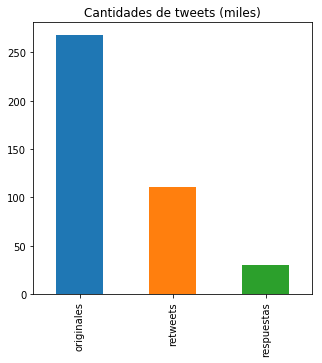

In [11]:
%%time
print_dataset_proportions(df)

### 1.1 Proporciones de RT sobre tweets totales (Recorte 1)

Cantidad de tweets originales: 		267784
Cantidad de RT en el Dataset: 		25455
Cantidad de respuestas a tweets: 	22164
Total: 					293239

Proporcion de RT sobre total: 			0.08680632521595012
Proporcion de Tweets originales sobre total: 	0.9131936747840499
Proporcion de Tweets respuestas a tweets sobre total: 	0.07558339784271532

Cantidad tweets comentados y retweeteados: 	3071
Cantidad tweets comentados y NO retweeteados: 	19093
Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!
CPU times: user 385 ms, sys: 120 ms, total: 505 ms
Wall time: 360 ms


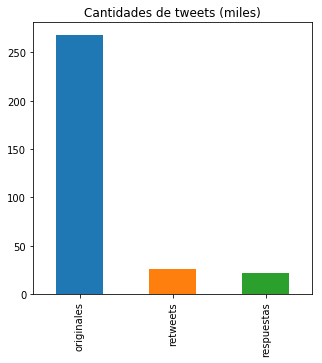

In [12]:
%%time
df_cutted = df_cut1(df)
print_dataset_proportions(df_cutted)

### 2 Promedio de conteos de retweets (usando retweet_count de la API de twitter)

In [13]:
def print_global_retweet_counts(data_f):
    avg_retweets_all = data_f.retweet_count.mean()
    print('Promedio de retweet counts (todo el dataset): \t\t{}'.format(avg_retweets_all))

    avg_retweets_nort = df_not_rt(data_f).retweet_count.mean()
    print('Promedio de retweet counts (solo tweets originales): \t{}'.format(avg_retweets_nort))

    # as retweets may point to the same tweet, we drop duplicates keeping the most updated one (oldest)
    avg_retweets_onlyrt =  df_only_rt(data_f).sort_values('created_at').drop_duplicates('retweeted_status__id_str', keep='last')\
        .retweet_count.mean()
    print('Promedio de retweet counts (solo retweets): \t\t{}'.format(avg_retweets_onlyrt))

### 2.0 Promedio de conteos de retweets (Global)

In [14]:
%%time
print_global_retweet_counts(df)

Promedio de retweet counts (todo el dataset): 		230.27960739243582
Promedio de retweet counts (solo tweets originales): 	20.10311669106444
Promedio de retweet counts (solo retweets): 		340.61649884960786
CPU times: user 207 ms, sys: 0 ns, total: 207 ms
Wall time: 205 ms


### 2.1 Promedio de conteos de retweets (Recorte 1)

In [15]:
%%time
df_cutted = df_cut1(df)
print_global_retweet_counts(df_cutted)

Promedio de retweet counts (todo el dataset): 		43.183539706519255
Promedio de retweet counts (solo tweets originales): 	20.10311669106444
Promedio de retweet counts (solo retweets): 		127.1447774501063
CPU times: user 276 ms, sys: 4.01 ms, total: 280 ms
Wall time: 276 ms


# Recorte 2: tomar sólo usuarios para los que se trajo el máximo de tweets por fetch_timeline

[Aquí](https://developer.twitter.com/en/docs/tweets/timelines/api-reference/get-statuses-user_timeline.html) se puede ver que 3,200 es el máximo de tweets que se puede traer. Se filtra entonces los usuarios para los cuales se extrajo esa cantidad de tweets.

Se usará 'Recorte 2' para referirse a esa filtrado de tweets

In [16]:
def df_cut2(data_f, max_tweets=3200):
    _df_tweets_per_user = data_f.user__id_str.groupby(data_f.user__id_str).count()
    data_f['user_tweets_on_dataset'] = _df_tweets_per_user[data_f.user__id_str.values].values
    return data_f[data_f.user_tweets_on_dataset >= max_tweets]


### 3 Ventanas de tiempo recogidas

In [17]:
def print_time_windows(data_f):
    print('Tweet más temprano en el tiempo: \t{}'.format(data_f.created_at.min()))
    print('Tweet más tardío en el tiempo: \t\t{}'.format(data_f.created_at.max()))

    max_of_mins = data_f.created_at.groupby(data_f.user__id_str).min().max()
    print('Menor fecha de tweet disponible para todos los usuarios: {}'.format(max_of_mins))

### 3.0 Ventanas de tiempo recogidas (Global)

In [18]:
%%time
print_time_windows(df)

Tweet más temprano en el tiempo: 	2018-10-28 00:00:00
Tweet más tardío en el tiempo: 		2018-11-04 23:59:56
Menor fecha de tweet disponible para todos los usuarios: 2018-11-04 23:45:16
CPU times: user 45.4 ms, sys: 3.96 ms, total: 49.4 ms
Wall time: 47.5 ms


### 3.1 Ventanas de tiempo recogidas (Recorte 1)

In [19]:
%%time
df_cutted = df_cut1(df)
print_time_windows(df_cutted)

Tweet más temprano en el tiempo: 	2018-10-28 00:00:00
Tweet más tardío en el tiempo: 		2018-11-04 23:59:55
Menor fecha de tweet disponible para todos los usuarios: 2018-11-04 23:10:38
CPU times: user 205 ms, sys: 3.95 ms, total: 209 ms
Wall time: 208 ms


### 3.2 Ventanas de tiempo recogidas (Recorte 2)

In [20]:
%%time
df_cutted = df_cut2(df)
print_time_windows(df_cutted)

Tweet más temprano en el tiempo: 	2018-10-28 00:01:22
Tweet más tardío en el tiempo: 		2018-11-04 23:57:40
Menor fecha de tweet disponible para todos los usuarios: 2018-10-28 00:10:08
CPU times: user 134 ms, sys: 27 µs, total: 134 ms
Wall time: 132 ms


In [21]:
tweets_on_tweet_limit = df_cutted.shape[0]
users_on_tweet_limit = df_cutted.user__id_str.value_counts().count()
print('Tweets que tienen (igual) o más que el límite de tweets: {}'.format(tweets_on_tweet_limit))
print('Users que tienen (igual) o más que el límite de tweets: {}'.format(users_on_tweet_limit))

Tweets que tienen (igual) o más que el límite de tweets: 7578
Users que tienen (igual) o más que el límite de tweets: 2


### 4 Histograma de tweets y retweets por fecha

In [22]:
def plot_tweets_and_retweets_by_date(data_f):
    print('Valores a plotear: {}'.format(data_f.shape[0]))
    fig, ax = plt.subplots(figsize=(10,5))
    (data_f.created_at.groupby(data_f["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Todos los tweets')
    (data_f.created_at.groupby(df_only_rt(data_f)["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Solo RT')
    (data_f.created_at.groupby(df_commented(data_f)["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Solo con commentarios')
    ax.set_title('Histograma de tweets por fecha')
    ax.set_ylabel('cantidad (miles)')
    ax.set_xlabel('fecha')

### 4.0 Histograma de tweets y retweets por fecha (Global)

Valores a plotear: 378495
CPU times: user 434 ms, sys: 94 µs, total: 434 ms
Wall time: 473 ms


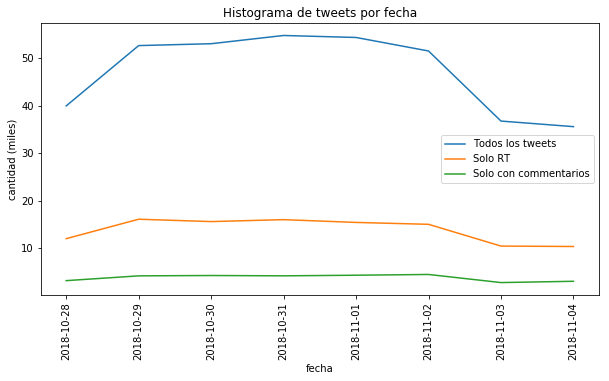

In [23]:
%%time
plot_tweets_and_retweets_by_date(df)

### 4.1 Histograma de tweets y retweets por fecha (Recorte 1)

Valores a plotear: 293239
CPU times: user 577 ms, sys: 92.2 ms, total: 669 ms
Wall time: 536 ms


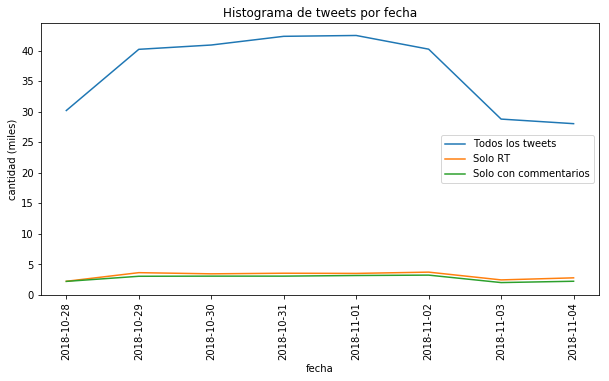

In [24]:
%%time
df_cutted = df_cut1(df)
plot_tweets_and_retweets_by_date(df_cutted)

### 4.2 Histograma de tweets y retweets por fecha (Recorte 2)

Valores a plotear: 7578


TypeError: Empty 'DataFrame': no numeric data to plot

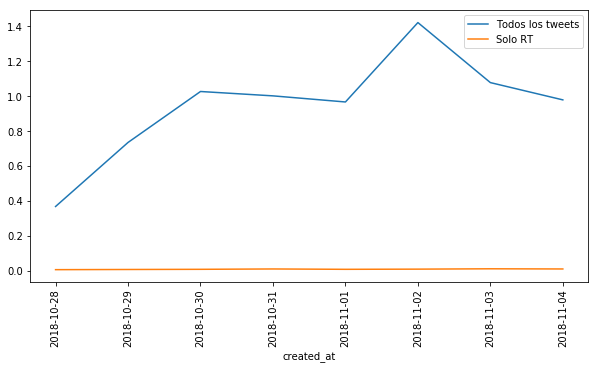

In [25]:
%%time
df_cutted = df_cut2(df)
plot_tweets_and_retweets_by_date(df_cutted)

### 5 Histograma de tweets y retweets por hora

Nota: se dejan afuera las primeras n horas por exceder los ordenes de magnitud para el ploteo

In [48]:
def plot_retweets_per_hour(data_f):
    data_f = data_f.copy()
    data_f['time_diff'] = df_only_rt(data_f).created_at - df_only_rt(data_f).retweeted_status__created_at
    # agregar columna de primer aparicion en el dataset (created at oo si es RT, primer RT en el grupo)
    counts_per_hour = df_only_rt(data_f).time_diff.groupby((df_only_rt(data_f).time_diff / np.timedelta64(1, 'h')).round(0)).count()
    
    def _find_first_n_outliers():
        head = counts_per_hour[0]
        for i in range(1, len(counts_per_hour)):
            if head < 2 * counts_per_hour[i]:
                break
            head = counts_per_hour[i]
        return i
    n_head_outliers = _find_first_n_outliers()
    first_n_hours_considered = 56

    print(counts_per_hour.head(n_head_outliers))
    print('Hay {} valores a plotear'.format(counts_per_hour.count()))
    counts_per_hour.head(first_n_hours_considered)[n_head_outliers:].plot(kind="line")

### 5.0 Histograma de tweets y retweets por hora (Global)

time_diff
0.0    44070
1.0    14603
Name: time_diff, dtype: int64
Hay 1340 valores a plotear
CPU times: user 341 ms, sys: 803 µs, total: 342 ms
Wall time: 340 ms


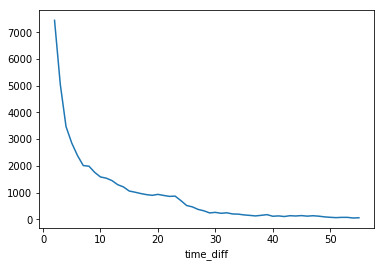

In [49]:
%%time
counts = plot_retweets_per_hour(df)

### 5.1 Histograma de tweets y retweets por hora (Recorte 1)

time_diff
0.0    9654
1.0    3457
Name: time_diff, dtype: int64
Hay 114 valores a plotear
CPU times: user 370 ms, sys: 398 µs, total: 371 ms
Wall time: 367 ms


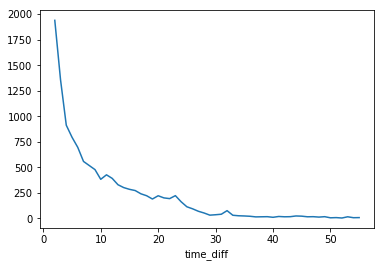

In [50]:
%%time
df_cutted = df_cut1(df)
counts = plot_retweets_per_hour(df_cutted)

### 5.2 Histograma de tweets y retweets por hora (Recorte 2)

time_diff
0.0    47
1.0    21
Name: time_diff, dtype: int64
Hay 3 valores a plotear
CPU times: user 252 ms, sys: 80 ms, total: 332 ms
Wall time: 202 ms


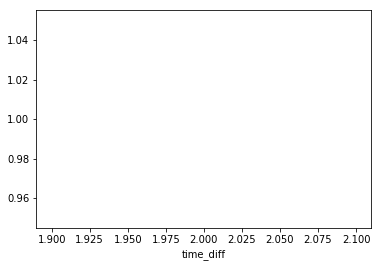

In [29]:
%%time
df_cutted = df_cut2(df)
counts = plot_retweets_per_hour(df_cutted)

### Retweets por hora de n tweets más retweeteados (en el dataset)

In [117]:
def annotate_df_with_rt_on_dataset(data_f):
    # dict-like series: key = retweeted_status__id_str  -> value = how many times was RTed in dataset
    _df_tweets_per_user = data_f.retweeted_status__id_str.groupby(data_f.retweeted_status__id_str).count()
    # add key for NaNs -> to be set to 0
    _df_tweets_per_user.loc['-1'] = 0
    # get data frame's retweeted_status__id_str field for completition.
    a = data_f.retweeted_status__id_str.fillna('-1').values
    # update Retweets
    data_f['rt_on_dataset'] = _df_tweets_per_user[a].values
    # update only original tweets # TODO

def get_top_retweeted(data_f, n=5):
    annotate_df_with_rt_on_dataset(data_f)
    top_retweeted = data_f.drop_duplicates('rt_on_dataset').nlargest(5, 'rt_on_dataset', keep='last')
    return top_retweeted.head(n)

def plot_tweets_per_hour(t_id, use_percentage=False):
    """For single tweet"""
    data_f = df[df.retweeted_status__id_str == str(t_id)]
    total = data_f.iloc[0].rt_on_dataset
    data_f['time_diff'] = data_f.created_at - data_f.retweeted_status__created_at

    # filter on max_hour ? TODO
    per_hour = (data_f.time_diff.groupby((data_f.time_diff / np.timedelta64(1, 'h')).round(0)).count())
    if use_percentage:
        per_hour = per_hour / total

    fig, axes = plt.subplots(ncols=2)
    per_hour.plot(kind="line", ax=axes[0],figsize=(15, 4))
    axes[0].set_title('Histograma de RT por hora a partir del tweet')
    axes[0].set_ylabel('cantidad')
    axes[0].set_xlabel('hora')
    per_hour.cumsum().plot(kind='line', ax=axes[1])
    axes[1].set_title('Histograma de RT por hora a partir del tweet acumulado')
    axes[1].set_ylabel('cantidad')
    axes[1].set_xlabel('hora')

RTs to be plotted for df: 101
RTs to be plotted for df: 95


/home/emanuel/.virtualenvs/sna-famaf/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RTs to be plotted for df: 77
RTs to be plotted for df: 71
RTs to be plotted for df: 70


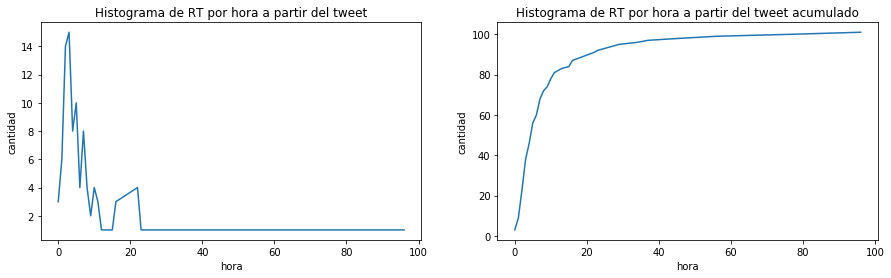

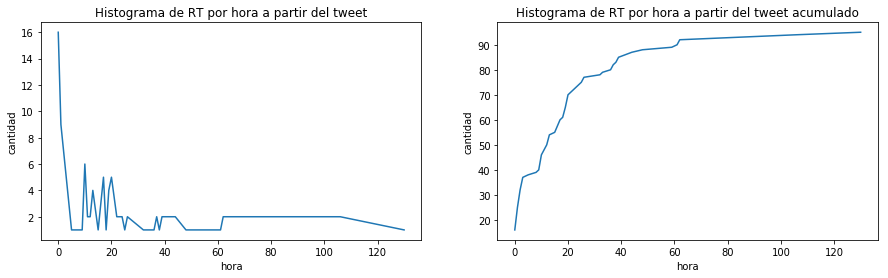

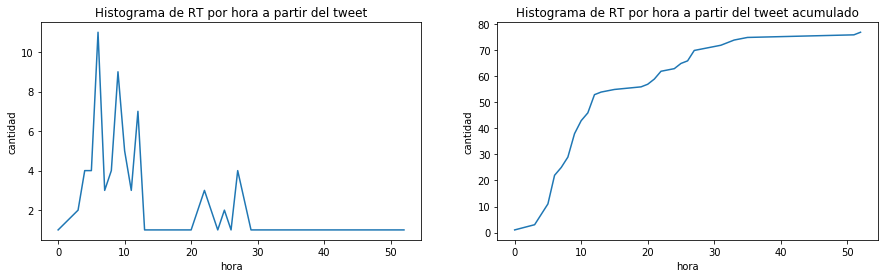

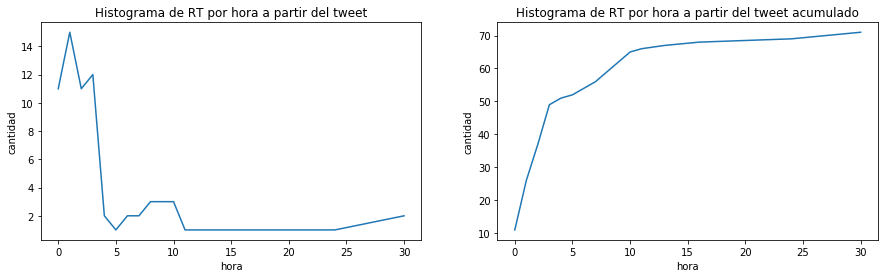

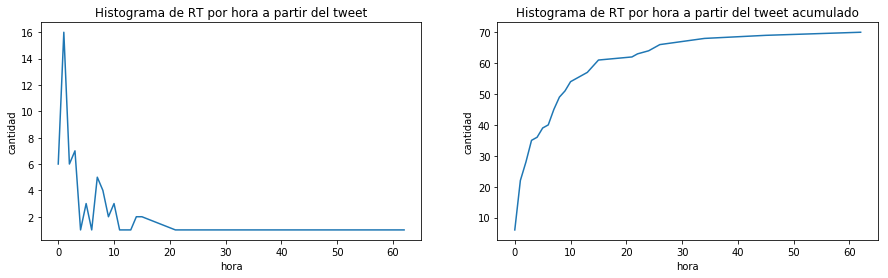

In [118]:
top_retweeted = get_top_retweeted(df)
for t_id in top_retweeted.retweeted_status__id_str:
    retweeted = df[df.retweeted_status__id_str == str(t_id)]
    print('RTs to be plotted for df: {}'.format(retweeted.shape[0]))
    plot_tweets_per_hour(t_id, use_percentage=False)

### Retweets por hora en general (porcentajes)

In [ ]:
data_f = df.copy()
annotate_df_with_rt_on_dataset(data_f)
data_f['time_diff'] = df_only_rt(data_f).created_at - df_only_rt(data_f).retweeted_status__created_at
per_hour = df_only_rt(data_f).time_diff.groupby((df_only_rt(data_f).time_diff / np.timedelta64(1, 'h')).round(0)).count()
df_only_rt(data_f)

# on progress


# total = data_f.iloc[0].rt_on_dataset
# data_f['time_diff'] = data_f.created_at - data_f.retweeted_status__created_at

# # filter on max_hour ? TODO
# per_hour = (data_f.time_diff.groupby((data_f.time_diff / np.timedelta64(1, 'h')).round(0)).count())
# if use_percentage:
#     per_hour = per_hour / total

# fig, axes = plt.subplots(ncols=2)
# per_hour.plot(kind="bar", ax=axes[0],figsize=(15, 4))
# per_hour.cumsum().plot(kind='bar', ax=axes[1])
# de[0:2].sum(), de[0:2]